In [21]:
# https://youtu.be/ScdCQqLtnis
"""
@author: Sreenivas Bhattiprolu

Code to train batches of cropped BraTS 2020 images using 3D U-net.

Please get the data ready and define custom data gnerator using the other
files in this directory.

Images are expected to be 128x128x128x3 npy data (3 corresponds to the 3 channels for 
                                                  test_image_flair, test_image_t1ce, test_image_t2)
Change the U-net input shape based on your input dataset shape (e.g. if you decide to only se 2 channels or all 4 channels)

Masks are expected to be 128x128x128x3 npy data (4 corresponds to the 4 classes / labels)


You can change input image sizes to customize for your computing resources.
"""


import os
import numpy as np
from python import DataGenerator
from python import UnetModel
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

import segmentation_models_3D as sm


In [2]:
train_img_dir = "../data/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "../data/BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])

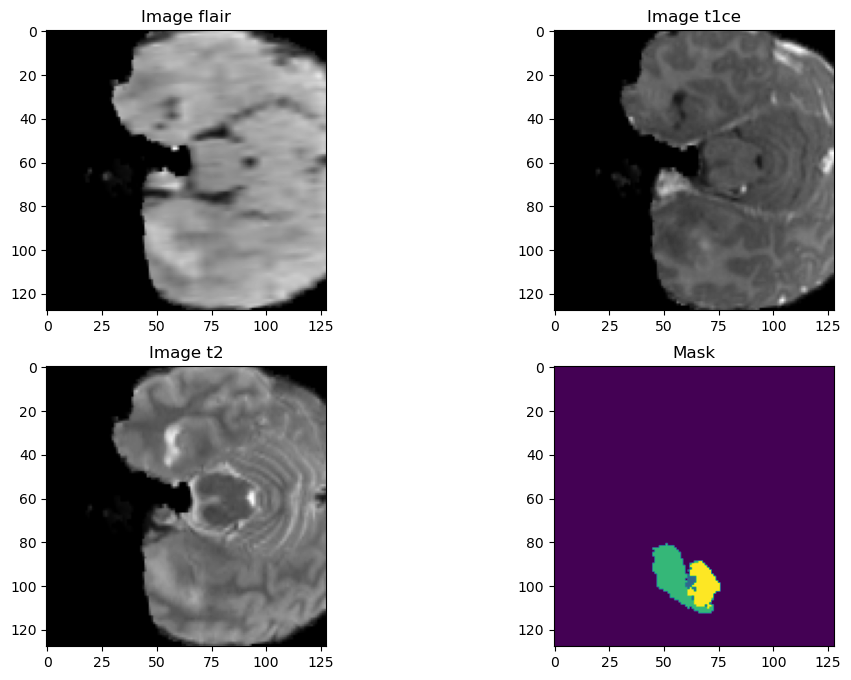

In [3]:
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [4]:
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

import pandas as pd
import numpy as np
import glob

columns = ['0', '1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('../data/BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))

for img in range(len(train_mask_list)):
    print(img)
    temp_image = np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    conts_dict = dict(zip(val.astype(str), counts))  # Ensure keys are strings matching 'columns'
    
    # Create a DataFrame from conts_dict with one row
    temp_df = pd.DataFrame([conts_dict], columns=columns)
    
    # Concatenate the new row to the existing DataFrame
    df = pd.concat([df, temp_df], ignore_index=True)

# Calculate label sums
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['2'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

# Class weights calculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels / (n_classes * label_0)), 2) if label_0 != 0 else 0
wt1 = round((total_labels / (n_classes * label_1)), 2) if label_1 != 0 else 0
wt2 = round((total_labels / (n_classes * label_2)), 2) if label_2 != 0 else 0
wt3 = round((total_labels / (n_classes * label_3)), 2) if label_3 != 0 else 0

# Weights can be used for Dice loss

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257


In [5]:
print(f"Weights are: {wt0}, {wt1}, {wt2}, {wt3}")

Weights are: 0.26, 22.92, 9.02, 26.65


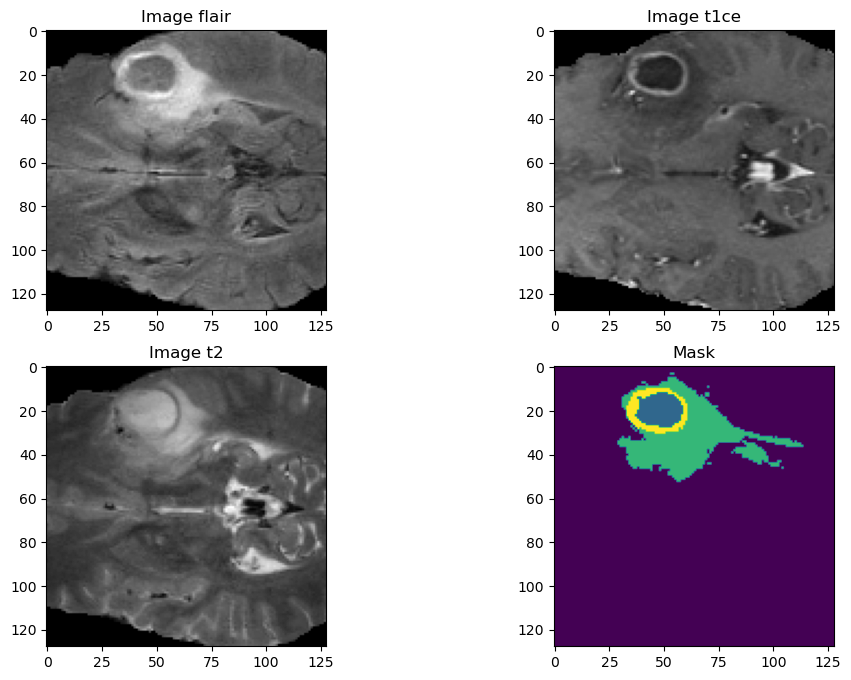

In [19]:
#Define the image generators for training and validation

train_img_dir = "../data/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "../data/BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "../data/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "../data/BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)


#################################################################################


batch_size = 2

train_img_datagen = DataGenerator.imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = DataGenerator.imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [25]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

#######################################################################
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


#from  unet_model import simple_unet_model

model = UnetModel.simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,312 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)
Epoch 1/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 1457s 11s/step - accuracy: 0.8357 - iou_score: 0.1521 - loss: 0.9713 - val_accuracy: 0.7259 - val_iou_score: 0.2149 - val_loss: 0.9569
Epoch 2/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 1452s 11s/step - accuracy: 0.9281 - iou_score: 0.2809 - loss: 0.9326 - val_accuracy: 0.9199 - val_iou_score: 0.3150 - val_loss: 0.9256
Epoch 3/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 1459s 11s/step - accuracy: 0.9441 - iou_score: 0.3002 - loss: 0.9214 - val_accuracy: 0.9126 - val_iou_score: 0.3273 - val_loss: 0.9232


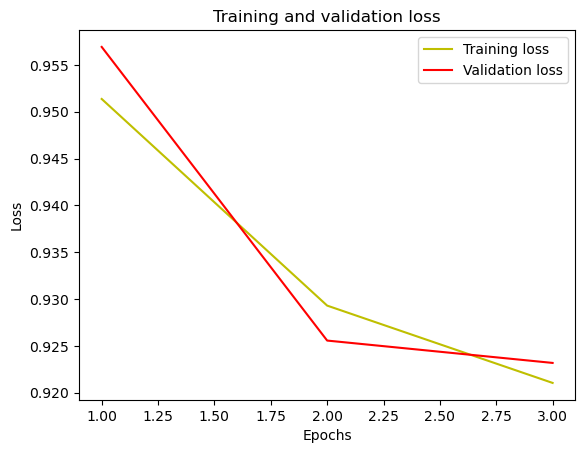

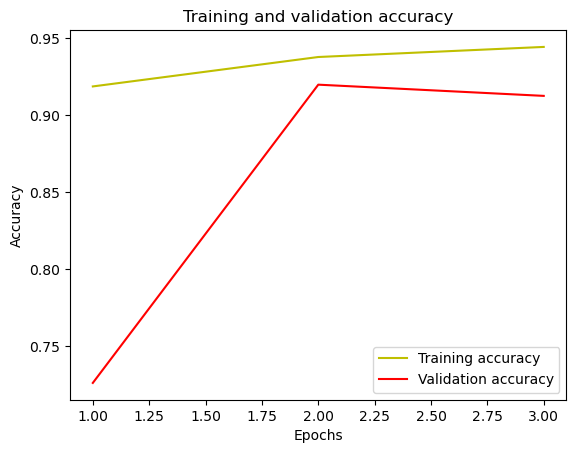

In [8]:


model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=3,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('brats_3d.hdf5')

##################################################################


#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Eventual compilation if ever needed:

In [27]:
# from keras.models import load_model

# #Load model for prediction or continue training

# # For continuing training....
# # The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
# # This is because the model does not save loss function and metrics. So to compile and 
# # continue training we need to provide these as custom_objects.
# # my_model = load_model('../notebooks/brats_3d.hdf5')

# # So let us add the loss as custom object... but the following throws another error...
# # Unknown metric function: iou_score
# my_model = load_model('../notebooks/brats_3d.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss})

# #Now, let us add the iou_score function we used during our initial training
# my_model = load_model('../notebooks/brats_3d.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5)})

# #Now all set to continue the training process. 
# history2=my_model.fit(train_img_datagen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=1,
#           verbose=1,
#           validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch,
#           )


In [14]:
#from ipynb.fs.full.tutorial_data_generator import imageLoader
#For predictions you do not need to compile the model, so ...
my_model = load_model('../notebooks/brats_3d.hdf5', 
                      compile=False)

For semantic segmentation, the Mean Intersection over Union (Mean IoU) is one of the most commonly used metrics to evaluate model performance. Semantic segmentation involves assigning a class label to every pixel in an image. Mean IoU evaluates how well your model predicts these pixel-level labels compared to the ground truth.

High Mean IoU (>0.8):
- Indicates the model is performing very well, with good overlap between predictions and ground truth.
Moderate Mean IoU (0.5 −0.8):
- Suggests reasonable performance but room for improvement.
Low Mean IoU (<0.5):
- Indicates poor segmentation. The model may be overfitting, underfitting, or struggling with specific classes.

In [20]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = DataGenerator.imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Mean IoU = 0.37981963


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step


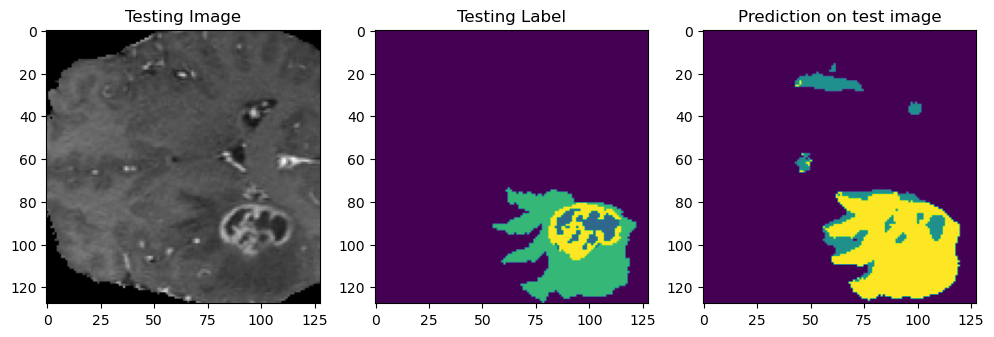

In [16]:
#Predict on a few test images, one at a time
#Try images: 
img_num = 82

test_img = np.load("../data/BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("../data/BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

############################################################